## streamflow and snowpack in the southern sierra


In [2]:
import os
import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ee
from climata.usgs import DailyValueIO
import rasterio
import rasterio.plot
import osr
import gdal
import ogr

ee.Initialize()

In [3]:
files = [os.path.join(shape,x) for x in os.listdir(shape) if "1803_hu8" in x]
t = gp.read_file(files[0])

NameError: name 'shape' is not defined

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
plt.title("HUC8s within Tulare Subbasin")
t.plot(column="HUC8", alpha=0.5, categorical=False, legend=True, ax=ax)

plt.show()

In [182]:
hu8s = []
for i in list(kml['HUC8']):
    hu8s.append(i)

In [ ]:
# Get Streamflow for each huc8 

In [245]:
def get_stremflow(huc8):
    
    '''
    call climata API supplying huc8 argument to get each gaging station within each basin 
    '''
    
    data =  DailyValueIO (
            start_date="1980-01-01", 
            end_date="2018-01-01",
            basin=huc8,
            parameter="00060",
            )
    
    qs = []
    ds = []
    lats = []
    lons = []

    for series in data:
        values = []
        dates = []
        lats.append(series.latitude)
        lons.append(series.longitude)

        for row in series.data:
            values.append(row.value)
            dates.append(row.date)

        qs.append(values)
        ds.append(dates)
    
    geometry = [Point(xy) for xy in zip(lons, lats)]
    df = pd.DataFrame(geometry)
    crs = {'init': 'epsg:4326'}
    gdf = gp.GeoDataFrame(df, crs=crs, geometry=geometry)
    
    return gdf, qs, ds

In [246]:
gdfs = []
qs = []
ds = []

for i in hu8s:
    gdf, q, d = get_stremflow(i)
    gdfs.append(gdf)
    qs.append(q)
    ds.append(d)


In [247]:
f_gdf = pd.concat(gdfs)

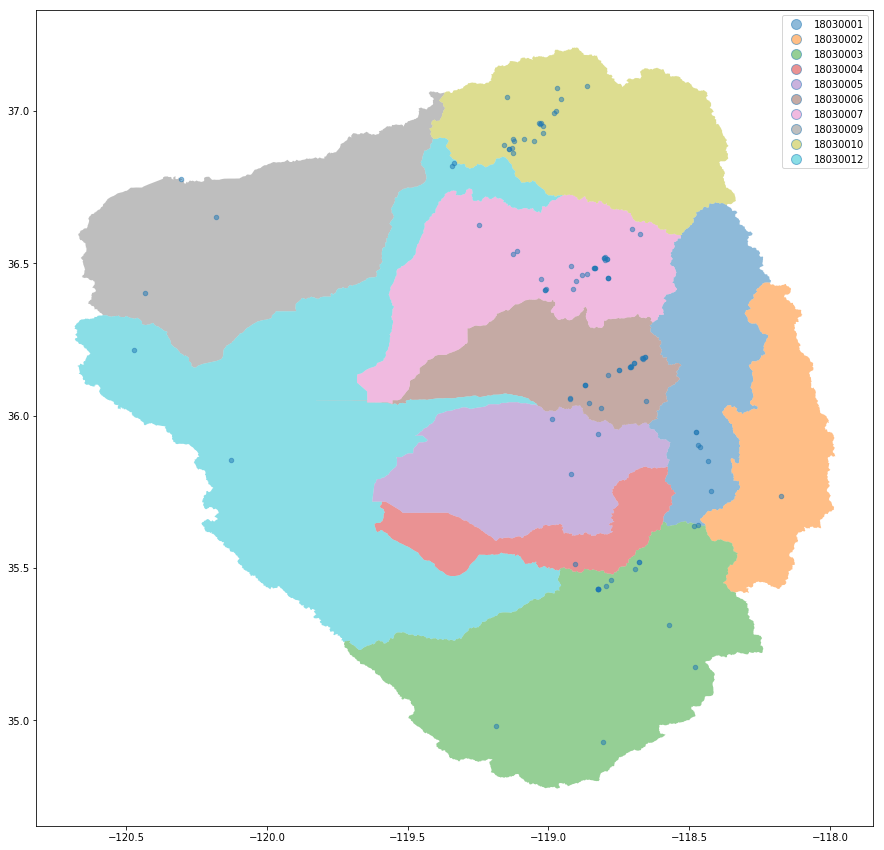

In [248]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
base = t.plot(column="HUC8", alpha=0.5, categorical=False, legend=True, ax=ax)
f_gdf.plot(ax=base, marker="o",markersize = 20, alpha=0.5)

plt.show()

In [249]:
flat_q = [item for sublist in qs for item in sublist]
flat_d = [item for sublist in ds for item in sublist]

fq = np.array(flat_q)

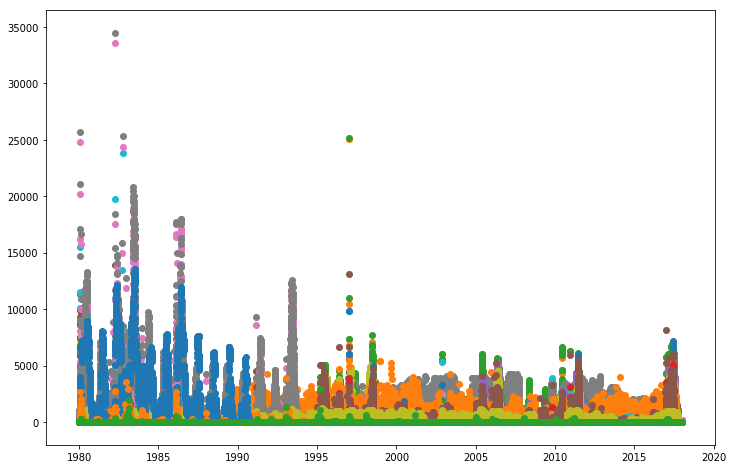

In [250]:
plt.figure(figsize = (12,8))
plt.title()

for i,x in enumerate(flat_q):
    plt.scatter(flat_d[i], np.abs(fq[i]))
    
plt.show()

# Snowpack (MODIS)

In [320]:
snow = ee.ImageCollection('MODIS/006/MOD10A1').filter(ee.Filter.date('2017-10-01', '2018-05-01')).select('NDSI_Snow_Cover')

In [321]:
lls = t[t['HUC8'] == hu8s[4]].geometry.iloc[0]
x,y = lls.exterior.coords.xy

In [322]:
eep = [list(zip(x,y))]

In [323]:
g = ee.Geometry.Polygon(eep);

In [324]:
im = snow.filterBounds(g).max()

In [325]:
# get the lat lon and add the ndvi
latlon = ee.Image.pixelLonLat().addBands(im)
 
# apply reducer to list
latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=g,
  maxPixels=1e8,
  scale=500);
 
# get data into three different arrays
data = np.array((ee.Array(latlon.get("NDSI_Snow_Cover")).getInfo()))
lats = np.array((ee.Array(latlon.get("latitude")).getInfo()))
lons = np.array((ee.Array(latlon.get("longitude")).getInfo()))
 
# get the unique coordinates
uniqueLats = np.unique(lats)
uniqueLons = np.unique(lons)
 
# get number of columns and rows from coordinates
ncols = len(uniqueLons)    
nrows = len(uniqueLats)
 
# determine pixelsizes
ys = uniqueLats[1] - uniqueLats[0] 
xs = uniqueLons[1] - uniqueLons[0]
 
# create an array with dimensions of image
arr = np.zeros([nrows, ncols], np.float32) #-9999
 
# fill the array with values
counter =0
for y in range(0,len(arr),1):
    for x in range(0,len(arr[0]),1):
        if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
            counter+=1
            arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
 

In [348]:

transform = (np.min(uniqueLons),xs,0,np.max(uniqueLats),0,-ys)
 
# set the coordinate system
target = osr.SpatialReference()
target.ImportFromEPSG(4326)
 
# set driver
driver = gdal.GetDriverByName('GTiff')
 
outputDataset = driver.Create("asdf2.tif", ncols,nrows, 1,gdal.GDT_Float32)
 
# add some metadata 
outputDataset.SetGeoTransform(transform)
outputDataset.SetProjection(target.ExportToWkt())
outputDataset.GetRasterBand(1).WriteArray(arr)
outputDataset.GetRasterBand(1).SetNoDataValue(-9999)
outputDataset = None

In [355]:
import rasterio
files = [x for x in os.listdir(os.getcwd()) if x.endswith(".tif")]
files

['asdf.tif', 'asdf2.tif']

In [399]:
ds = gdal.Open(files[0])

In [401]:
data = ds.ReadAsArray()

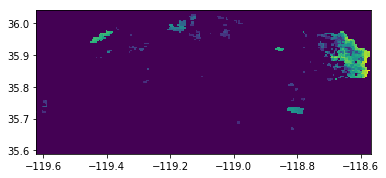

In [403]:
x0, dx, dxdy, y0, dydx, dy = ds.GetGeoTransform()

x1 = x0 + dx * ncols
y1 = y0 + dy * nrows

plt.imshow(data, extent=[x0, x1, y1, y0])
plt.show()

In [411]:
s = t[t["HUC8"] == hu8s[4]]

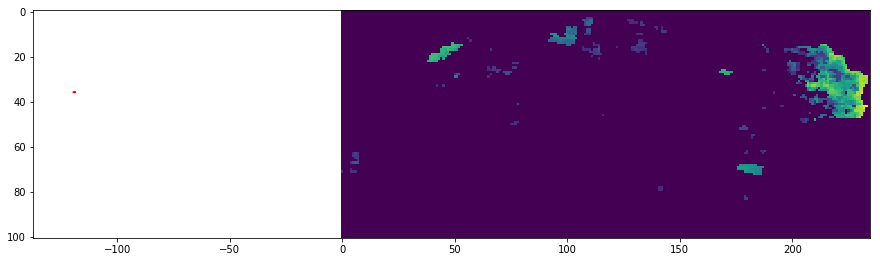

In [412]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(data)
s.plot(ax=ax, facecolor='none', edgecolor='red')

In [133]:
data = DailyValueIO(
    start_date="2000-01-01", 
    end_date="2018-01-01",
    basin="18030007",
    parameter="00060",
)

In [135]:
qs = []
ds = []
lats = []
lons = []

for series in data:
    values = []
    dates = []
    lats.append(series.latitude)
    lons.append(series.longitude)
    
    for row in series.data:
        values.append(row.value)
        dates.append(row.date)
        
    qs.append(values)
    ds.append(dates)

In [136]:
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(lons, lats)]
df = pd.DataFrame(geometry)
crs = {'init': 'epsg:4326'}
gdf = gp.GeoDataFrame(df, crs=crs, geometry=geometry)

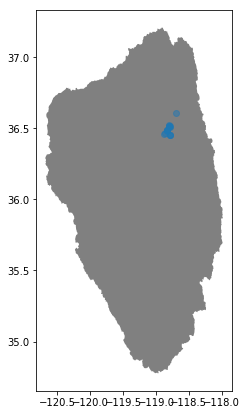

In [140]:
fig, ax = plt.subplots(1, figsize=(3.5,7))
base = tulare.plot(ax=ax, color='gray')
gdf.plot(ax=base, marker="o", alpha=0.5)
# _ = ax.axis('off')

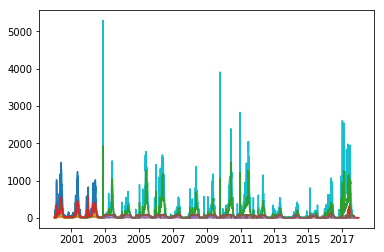

In [138]:
for i, x in enumerate(qs):
    plt.plot(ds[i],qs[i])

# Snowpack

In [108]:
import ee

ee.Initialize()

In [109]:
dataset = ee.ImageCollection('MODIS/006/MOD10A1').filter(ee.Filter.date('2018-01-01', '2018-05-01')).select('NDSI_Snow_Cover');

In [110]:
dataset.getInfo()

{'type': 'ImageCollection',
 'bands': [],
 'id': 'MODIS/006/MOD10A1',
 'version': 1548767837075215,
 'properties': {'date_range': [951350400000.0, 1548460800000.0],
  'period_mapping': [951350400000.0, 1548460800000.0],
  'period': 1.0,
  'system:visualization_0_min': '0.0',
  'system:visualization_0_bands': 'NDSI_Snow_Cover',
  'system:is_global': 1,
  'thumb': 'https://mw1.google.com/ges/dd/images/MOD10A1_thumb.png',
  'description': '<p>The MOD10A1 V6 Snow Cover Daily Global 500m product contains snow cover, snow albedo, fractional snow cover, and quality assessment (QA) data. Snow cover data are based on a snow mapping algorithm that employs a Normalized Difference Snow Index (NDSI) and other criteria tests.</p><p><b>Resolution</b><br>500 meters\n</p><p><b>Cadence</b><br>\n  1 day\n</p><p><b>Bands</b><table class="eecat"><tr><th scope="col">Name</th><th scope="col">Min</th><th scope="col">Max</th><th scope="col">Scale</th><th scope="col">Description</th></tr><tr><td>NDSI_Snow_Cover

In [103]:
from climata.snotel import RegionDailyDataIO

data = RegionDailyDataIO(
    start_date="2013-01-01",
    end_date="2013-12-31",
    basin="18010202",
    parameter="SNWD",
)


RegionDailyDataIOTuple(longitude=-121.33333, elevation=4800.0, data=<wq.io.util.FlatIO object at 0x11afcee10>, countyname=Klamath, fipsstatenumber=41, latitude=42.5, stationtriplet=21G12:OR:SNOW, stationdatatimezone=None, huc=180102020703, fipscountrycd=US, shefid=None, actonid=None, name=Bly 101 Ranch Pp&l (Disc), enddate=1971-12-31 00:00:00, hud=18010202, begindate=1938-01-01 00:00:00, fipscountycd=035)
RegionDailyDataIOTuple(longitude=-121.85, elevation=4190.0, data=<wq.io.util.FlatIO object at 0x11afe25f8>, countyname=Klamath, fipsstatenumber=41, latitude=42.58333, stationtriplet=21G07:OR:SNOW, stationdatatimezone=None, huc=180102020715, fipscountrycd=US, shefid=None, actonid=None, name=Chiloquin (Pp&l), enddate=2009-02-01 00:00:00, hud=18010202, begindate=1927-01-01 00:00:00, fipscountycd=035)
RegionDailyDataIOTuple(longitude=-120.94917, elevation=6180.0, data=<wq.io.util.FlatIO object at 0x11afb4358>, countyname=Klamath, fipsstatenumber=41, latitude=42.6381, stationtriplet=1010:O

In [106]:

for series in data:
    print (series)
    for row in series.data:
        print (row.data)

SyntaxError: invalid syntax (<ipython-input-106-276bcc25178d>, line 5)

In [91]:
vals = []
for series in data:
    print (series)
    print("asdf")

RegionDailyDataIOTuple(longitude=-118.293, elevation=7650.0, data=<wq.io.util.FlatIO object at 0x11a36a9b0>, countyname=Tulare, fipsstatenumber=06, latitude=36.122, stationtriplet=BHM:CA:SNOW, huc=180300010403, fipscountrycd=US, shefid=None, actonid=None, name=Beach Meadows, enddate=2100-01-01 00:00:00, begindate=1930-04-01 00:00:00, fipscountycd=107)
asdf
RegionDailyDataIOTuple(longitude=-118.837, elevation=9800.0, data=<wq.io.util.FlatIO object at 0x11b063278>, countyname=Fresno, fipsstatenumber=06, latitude=37.113, stationtriplet=BMD:CA:SNOW, huc=180300100601, fipscountrycd=US, shefid=None, actonid=None, name=Beard Meadow, enddate=2100-01-01 00:00:00, begindate=1930-04-01 00:00:00, fipscountycd=019)
asdf
RegionDailyDataIOTuple(longitude=-118.445, elevation=10600.0, data=<wq.io.util.FlatIO object at 0x11b2c5278>, countyname=Fresno, fipsstatenumber=06, latitude=36.958, stationtriplet=BNH:CA:SNOW, huc=180300100204, fipscountrycd=US, shefid=None, actonid=None, name=Bench Lake, enddate=2

In [ ]:
data=<wq.io.util.FlatIO object at 0x116323128>

In [45]:
qs = []
ds = []
lats = []
lons = []

for series in data:
    values = []
    dates = []
    lats.append(series.latitude)
    lons.append(series.longitude)
    
    for row in series.data:
        values.append(row.value)
        dates.append(row.date)
        
    qs.append(values)
    ds.append(dates)
    

geometry = [Point(xy) for xy in zip(lons, lats)]
df = pd.DataFrame(geometry)
crs = {'init': 'epsg:4326'}
gdf = gp.GeoDataFrame(df, crs=crs, geometry=geometry)

In [46]:
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(lons, lats)]
df = pd.DataFrame(geometry)
crs = {'init': 'epsg:4326'}
gdf = gp.GeoDataFrame(df, crs=crs, geometry=geometry)

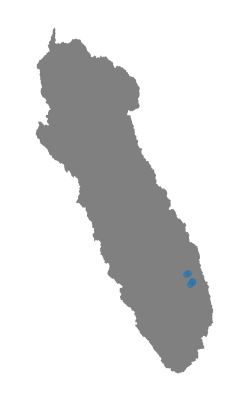

In [47]:
fig, ax = plt.subplots(1, figsize=(3.5,7))
base = t.plot(ax=ax, color='gray')
gdf.plot(ax=base, marker="o", alpha=0.5)
_ = ax.axis('off')

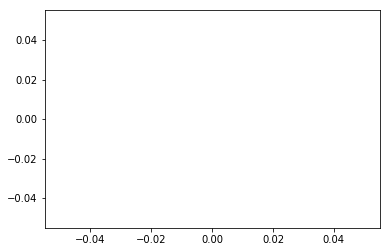

In [48]:
for i, x in enumerate(qs):
    plt.plot(ds[i],qs[i])